En este proyecto se presenta el proceso para la tarifacion de seguros automotores con el dataset de la Casualty ACtuarial Society: French Motor Third-Party Liability 2.

Otros tutoriales recomendables sobre este dataset (uno mas tecnico y otro mas academico), que realizan otros analisis eploratorios utiles, incluyen:

https://github.com/lorentzenchr/Tutorial_freMTPL2/blob/master/glm_freMTPL2_example.ipynb

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764

Para la finalidad principal por GLM, se puede optar por dos caminos, uno mas clasico si se puede decir, donde se modela la frecuencia y la severidad por separado, y la tarifacion se obtendra como el producto de sus esperanzas (camino que se tomara inicialmente). Y un camino directo, a traves de la distribucion tweedie y modelando directamente la prima (que tambien se desarollara)

LIBRERIAS Y FUNCIONES

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
import warnings
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_reset
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pygam
from pygam import s, l, te, f, PoissonGAM
from sklearn.model_selection import KFold
from itertools import product
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.5}'.format)

EXPLORATORY DATA ANALYSIS

Marcando _o para originales (luego se deben aplicar transformaciones), traemos los datos, y observamos con .head() que tipos de datos se observan

In [103]:
freq_o = pd.read_csv("C:/Program1/Proyectos/GLM Auto Insurance/freMTPL2freq.csv")
sev_o  = pd.read_csv("C:/Program1/Proyectos/GLM Auto Insurance/freMTPL2sev.csv")

In [104]:
freq_o

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
0,1.0,1,0.1,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
1,3.0,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
2,5.0,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
3,10.0,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
4,11.0,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6.1143e+06,0,0.0027397,4,0,54,50,B12,Regular,E,3317,Provence-Alpes-Cotes-D'Azur
678009,6.1143e+06,0,0.0027397,4,0,41,95,B12,Regular,E,9850,Ile-de-France
678010,6.1143e+06,0,0.0027397,6,2,45,50,B12,Diesel,D,1323,Rhone-Alpes
678011,6.1143e+06,0,0.0027397,4,0,60,50,B12,Regular,B,95,Bourgogne


In [105]:
sev_o

,IDpol,ClaimAmount
0,1552,995.2
1,1010996,1128.1
2,4024277,1851.1
3,4007252,1204.0
4,4046424,1204.0
...,...,...
26634,3254353,1200.0
26635,3254353,1800.0
26636,3254353,1000.0
26637,2222064,767.55


In [55]:
print(freq_o['ClaimNb'].value_counts())
print(freq_o['Exposure'].describe())
print(sev_o['ClaimAmount'].describe())

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64
count   6.7801e+05
mean       0.52875
std        0.36444
min      0.0027322
25%           0.18
50%           0.49
75%           0.99
max           2.01
Name: Exposure, dtype: float64
count   2.6639e+04
mean        2278.5
std     2.9297e+04
min            1.0
25%         686.81
50%         1172.0
75%         1228.1
max     4.0754e+06
Name: ClaimAmount, dtype: float64


Podemos ver como  hay outliers de la cantidad de reclamos y la severidad, y para el caso de la exposicion (en años) hay escenarios de mas de 1 (que consideraremos sin sentido para este caso). Vamos a recortarlos a numeros "razonables", tomando maximo de 4 reclamos por año, exposicion maxima de 1 y reclamo maximo de 100.000 (para modelado). Procedemos a ver si estos valores representan a nivel de cuantiles

In [56]:
(freq_o["ClaimNb"] <= 4).mean()

np.float64(0.9999867259182346)

In [57]:
(sev_o["ClaimAmount"] <= 100000).mean()

np.float64(0.9984233642403995)

Por otro lado para observar mejor la distribucion de los datos podemos utilizar histogramas. 

Para ClaimNb, podemos ver discrecion, los modelos que se ajustan son Poisson o Binomial Negativa (cuya diferencia radicara en la varianza)

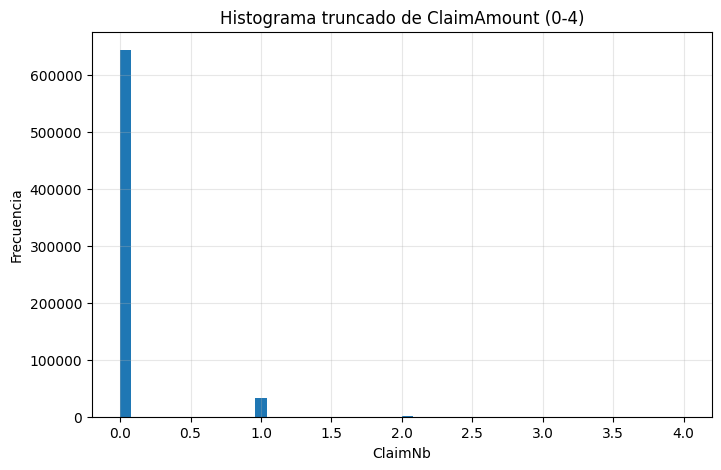

In [58]:
plt.figure(figsize=(8,5))
freq_o["ClaimNb"].hist(bins=50, range=(0,4))
plt.title("Histograma truncado de ClaimAmount (0-4)")
plt.xlabel("ClaimNb")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

En el caso de ClaimAmount (truncandolo debido a los outliers). Se puede ver que si los datos se acumulan a la izquierda de manera conitnua (esto se puede encrudecer a medida que aumentamos el rango), podriamos suponer el ajuste a una Gamma (o como aplicaremos mas adelante una Inversa Gaussiana)

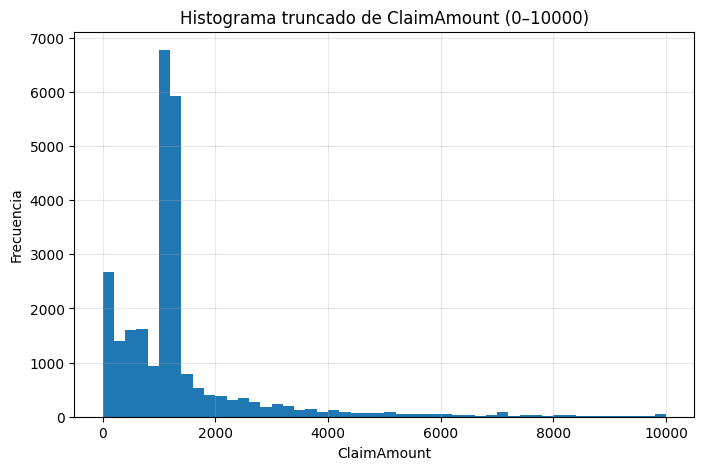

In [59]:
plt.figure(figsize=(8,5))
sev_o["ClaimAmount"].hist(bins=50, range=(0,10000))
plt.title("Histograma truncado de ClaimAmount (0–10000)")
plt.xlabel("ClaimAmount")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

DATA PREPARATION

Como se menciono, marcamos limites. Sumado a eso para el modelado de la severidad, trabajamos con valores mayores a 0

In [60]:
freq = freq_o.copy()

freq["Exposure"] = freq["Exposure"].clip(upper=1.0)
freq["ClaimNb"] = freq["ClaimNb"].clip(upper=4)
sev = sev_o.copy()
sev["ClaimAmount"] = sev["ClaimAmount"].clip(upper=100000)
sev = sev[sev["ClaimAmount"] > 0]

FRECUENCIAS

              total_claims  total_exposure  frequency
VehPower_bin                                         
(3.999, 5.0]         12932       1.282e+05    0.10087
(5.0, 6.0]            8381      8.2498e+04    0.10159
(6.0, 7.0]            7626       7.792e+04    0.09787
(7.0, 8.0]            1922      2.2674e+04   0.084767
(8.0, 15.0]           5195      4.7065e+04    0.11038


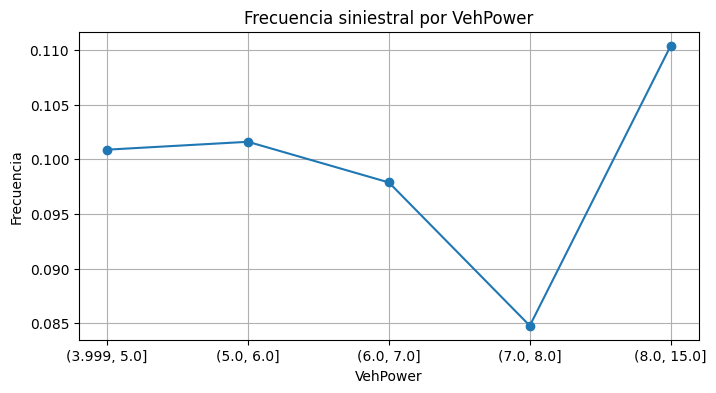

               total_claims  total_exposure  frequency
VehAge_bin                                            
(-0.001, 2.0]         10904      7.9138e+04    0.13778
(2.0, 4.0]             4602      4.9827e+04   0.092359
(4.0, 8.0]             8083       8.145e+04   0.099238
(8.0, 12.0]            7154       7.456e+04   0.095949
(12.0, 100.0]          5313      7.3384e+04     0.0724


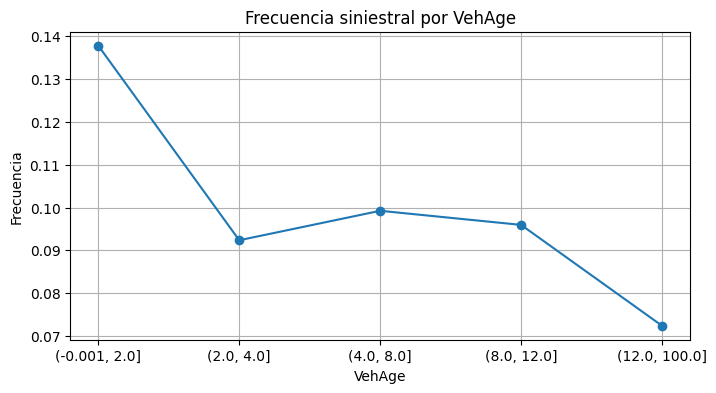

                total_claims  total_exposure  frequency
DrivAge_bin                                            
(17.999, 32.0]          7268      6.0729e+04    0.11968
(32.0, 40.0]            6188      6.8563e+04   0.090253
(40.0, 48.0]            7207       6.999e+04    0.10297
(48.0, 57.0]            7761      7.7306e+04    0.10039
(57.0, 100.0]           7632      8.1772e+04   0.093333


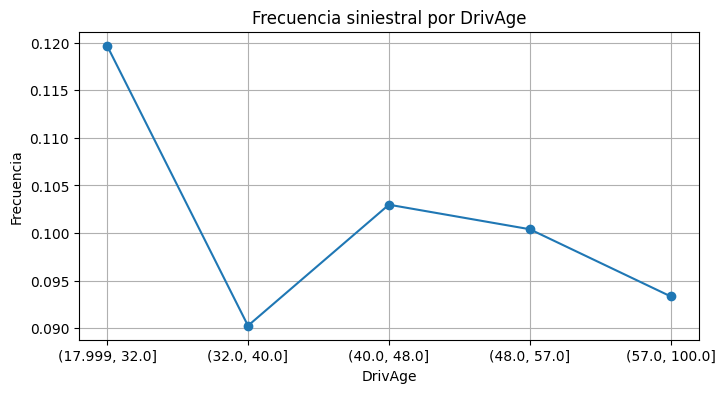

                total_claims  total_exposure  frequency
BonusMalus_bin                                         
(49.999, 53.0]         19063      2.3787e+05    0.08014
(53.0, 72.0]            8213      7.0762e+04    0.11607
(72.0, 230.0]           8780      4.9727e+04    0.17656


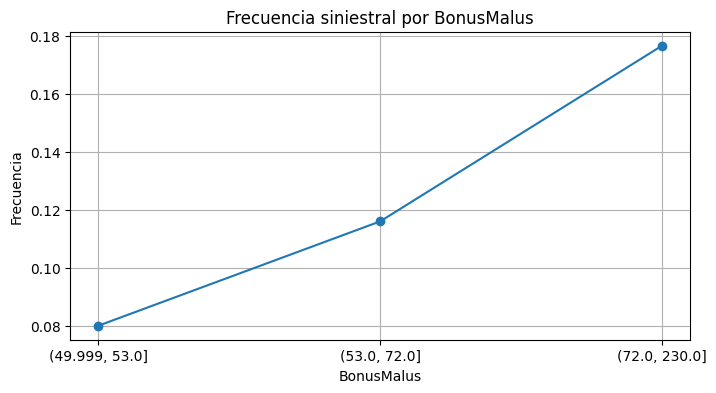

                   total_claims  total_exposure  frequency
Density_bin                                               
(0.999, 67.0]              6746      8.1392e+04   0.082883
(67.0, 214.0]              6743      7.4079e+04   0.091024
(214.0, 716.0]             7091      7.2007e+04   0.098476
(716.0, 2715.0]            7817      6.9457e+04    0.11254
(2715.0, 27000.0]          7659      6.1424e+04    0.12469


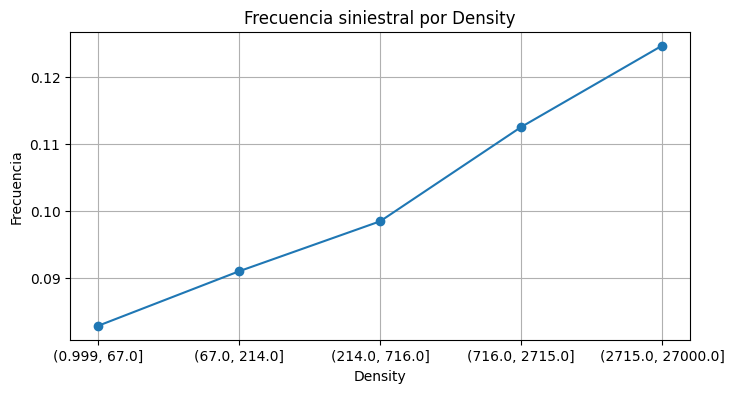

In [61]:
num_cols = [
    col for col in freq.select_dtypes(include=["int", "float"]).columns
    if "IDpol" not in col   # excluye IDpol
]
result_bins = {}

for col in num_cols:
    #no tiene sentido agrupar
    if col in ["ClaimNb", "Exposure"]:
        continue

    #   columnas categoricas
    freq[col + "_bin"] = pd.qcut(freq[col], q=5, duplicates="drop")

    ntemp = (
        freq.groupby(col + "_bin")
            .agg(
                total_claims=("ClaimNb", "sum"),
                total_exposure=("Exposure", "sum")
            )
    )
    ntemp["frequency"] = ntemp["total_claims"] / ntemp["total_exposure"]
    result_bins[col] = ntemp
    print(ntemp)
    plt.figure(figsize=(8,4))
    plt.plot(ntemp.index.astype(str), ntemp["frequency"], marker="o")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.title(f"Frecuencia siniestral por {col}")
    plt.grid(True)
    plt.show()

          total_claims  total_exposure  frequency
VehBrand                                         
B1                8639      9.5315e+04   0.090636
B10                858          9489.8   0.090412
B11                721          6883.1    0.10475
B12               8859      6.4802e+04    0.13671
B13                649          6768.0   0.095892
B14                166          2270.5   0.073111
B2                8552      9.4824e+04   0.090188
B3                2818      2.8576e+04   0.098613
B4                1312       1.377e+04   0.095279
B5                2020      1.9984e+04    0.10108
B6                1462      1.5677e+04   0.093255


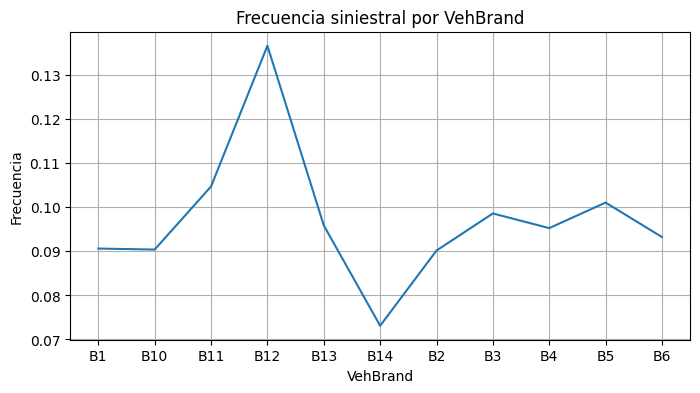

         total_claims  total_exposure  frequency
VehGas                                          
Diesel          16640      1.7059e+05   0.097545
Regular         19416      1.8777e+05     0.1034


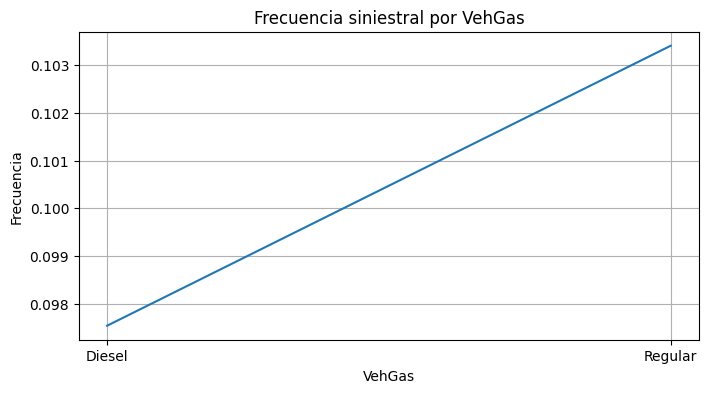

      total_claims  total_exposure  frequency
Area                                         
A             5056      6.1957e+04   0.081605
B             3800      4.3002e+04   0.088368
C             9875       1.044e+05   0.094586
D             8390      7.7088e+04    0.10884
E             7804      6.3786e+04    0.12235
F             1131          8125.4    0.13919


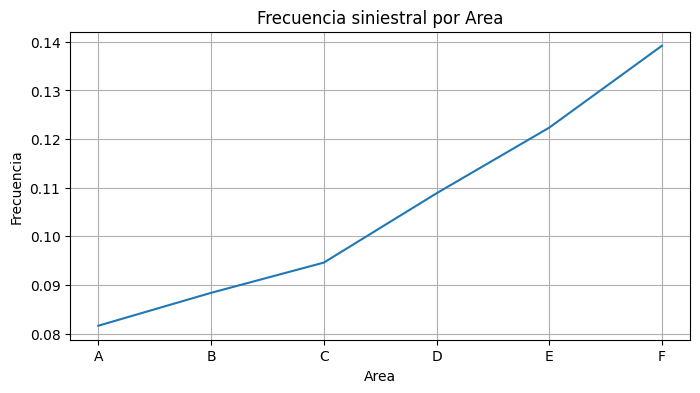

                             total_claims  total_exposure  frequency
Region                                                              
Alsace                                133          1208.6    0.11004
Aquitaine                            1348      1.4316e+04   0.094159
Auvergne                              189          2322.3   0.081386
Basse-Normandie                       633          6652.7    0.09515
Bourgogne                             511          5023.0    0.10173
Bretagne                             2702      2.7753e+04    0.09736
Centre                               9197      1.0271e+05   0.089546
Champagne-Ardenne                     160          1204.3    0.13285
Corse                                 247          1765.9    0.13987
Franche-Comte                          57          563.77     0.1011
Haute-Normandie                       303          3176.9   0.095377
Ile-de-France                        3978      3.0198e+04    0.13173
Languedoc-Roussillon              

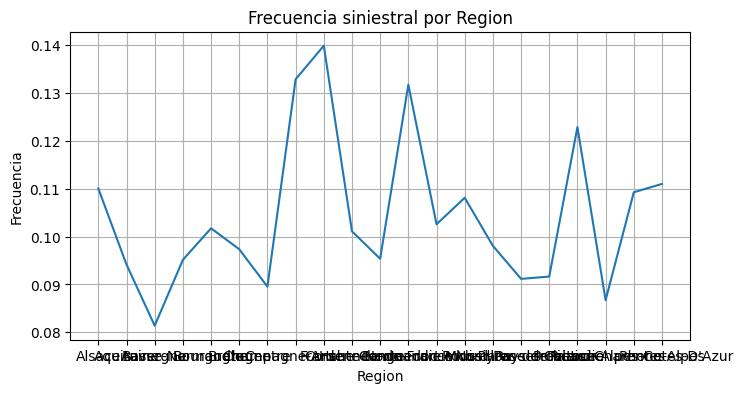

In [62]:
cat_cols = [
    col for col in freq.select_dtypes(include=["object", "category"]).columns
    if "_bin" not in col.lower()   # excluye binned
]
result_c = {}

for col in cat_cols:
    ctemp = (
        freq.groupby(col)
            .agg(
                total_claims=("ClaimNb", "sum"),
                total_exposure=("Exposure", "sum")
            )
    )
    ctemp["frequency"] = ctemp["total_claims"] / ctemp["total_exposure"]
    result_c[col] = ctemp
    print(ctemp)
    plt.figure(figsize=(8,4))
    plt.plot(ctemp.index.astype(str), ctemp["frequency"])
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.title(f"Frecuencia siniestral por {col}")
    plt.grid(True)
    plt.show()


En algunos pocos casos se poca frecuencia relativa, el comportamiento de las variables puede utilizarse luego para el agrupamiento si es que se encuentra no significatividad a la hora de modelar (agrupando comportamientos parecidos o exposicion reducida entre grupos para tener un aumento de esta)

CORRELACIONES

In [63]:
corr_matrix = freq[num_cols].corr(method='pearson')
target_corr = corr_matrix["ClaimNb"].sort_values(ascending=False)
corr_matrix
#target_corr #correlaciones para ClaimNb solo (1er columna)

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
ClaimNb,1.0,0.069744,-0.0039869,-0.022181,0.011312,0.051182,0.010924
Exposure,0.069744,1.0,-0.045398,0.15164,0.17202,-0.18309,-0.071196
VehPower,-0.0039869,-0.045398,1.0,-0.0060015,0.030108,-0.075895,0.042901
VehAge,-0.022181,0.15164,-0.0060015,1.0,-0.059213,0.079923,-0.090428
DrivAge,0.011312,0.17202,0.030108,-0.059213,1.0,-0.47997,-0.0046998
BonusMalus,0.051182,-0.18309,-0.075895,0.079923,-0.47997,1.0,0.077717
Density,0.010924,-0.071196,0.042901,-0.090428,-0.0046998,0.077717,1.0


Aunque el BonusMalus no se usara para el modelado (explicare mas adelante las razones), este parece tener correlacion con la edad del conductor. Por demas no se encuentra otra correlacion

In [64]:
for col in cat_cols:
    grupos = [group["ClaimNb"].values for _, group in freq.groupby(col)]
    fval, pval = spstats.f_oneway(*grupos) #anova contra freq
    print(f"{col}: p-value = {pval:.5f}")

VehBrand: p-value = 0.00010
VehGas: p-value = 0.00000
Area: p-value = 0.00000
Region: p-value = 0.00000


p < 0.05 -> es relevante para frecuencia de siniestro

In [65]:
for col in cat_cols:
    tabla = pd.crosstab(freq[col], freq["ClaimNb"] > 0) # siniestro sí/no
    chi2, p, dof, exp = spstats.chi2_contingency(tabla)
    print(f"{col}: p-value chi2 = {p:.5f}")


VehBrand: p-value chi2 = 0.00006
VehGas: p-value chi2 = 0.00000
Area: p-value chi2 = 0.00000
Region: p-value chi2 = 0.00000


 p < 0.05 -> variables asociadas con presencia (1 o 0) de siniestro

TRANSFORMAMOS PARA GLM

Estos "bins" o grupos, son mas "artesanales" (antes se realizaron por cuantil de manera automatica, agrupando en 5 partes). Se pueden realizar cambios en los valores y es recomendable, la eleccion que se haga puede no ser suficientemente representativa y resultar en valores no significativos.

In [66]:
#VehPower
VehPower_bins = [3,6,10,15]
VehPower_labels = ["Low", "Mid", "High"]
freq["VehPower_bins"] = pd.cut(freq["VehPower"], bins=VehPower_bins, labels=VehPower_labels)
#VehAge
VehAge_bins = [-1,5,10,100] #va desde -0.0001
VehAge_labels = ["BrandNew", "Used", "Old"]
freq["VehAge_bins"] = pd.cut(freq["VehAge"], bins=VehAge_bins, labels=VehAge_labels)
#DrivAge
DrivAge_bins = [17,35,55,101]
DrivAge_labels = ["Joven", "Adulto", "AdultoMayor"]
freq["DrivAge_bins"] = pd.cut(freq["DrivAge"], bins=DrivAge_bins, labels=DrivAge_labels)

In [67]:
def exp_rel(col):
    total_exp = freq["Exposure"].sum()
    exp_rel = (
        freq.groupby(col)["Exposure"]
            .sum()
            .sort_values()/ total_exp
    )
    return exp_rel

print(exp_rel("Area"), exp_rel("Region"), exp_rel("VehBrand"))

Area
F   0.022674
B       0.12
A    0.17289
E    0.17799
D    0.21511
C    0.29133
Name: Exposure, dtype: float64 Region
Franche-Comte                 0.0015732
Champagne-Ardenne             0.0033607
Alsace                        0.0033727
Corse                         0.0049278
Auvergne                      0.0064803
Limousin                      0.0066853
Haute-Normandie               0.0088651
Picardie                        0.00997
Bourgogne                      0.014017
Basse-Normandie                0.018564
Midi-Pyrenees                  0.019574
Poitou-Charentes                0.03115
Aquitaine                      0.039949
Languedoc-Roussillon            0.04105
Nord-Pas-de-Calais             0.054695
Pays-de-la-Loire               0.061196
Bretagne                       0.077444
Ile-de-France                  0.084268
Provence-Alpes-Cotes-D'Azur    0.099757
Rhone-Alpes                      0.1265
Centre                           0.2866
Name: Exposure, dtype: float64 VehBrand

No utilizaremos Region que posee valores menos expuestos, y que se encuentra abarcado en Area. Lo mismo aremos con la densidad.

Por parte de VehBrand agruparemos los valores poco representativos en "Other Brand"

In [68]:
freq["VehBrand_grp"] = freq["VehBrand"].replace({"B10": "OtherBrand", "B11": "OtherBrand", "B13": "OtherBrand", "B14": "OtherBrand", "B4": "OtherBrand","B6": "OtherBrand","B5": "OtherBrand","B3": "OtherBrand"})

MULTICOLINEALIDAD

In [69]:
X = freq[num_cols].copy()
X = X.assign(const=1)
xvif = pd.DataFrame()
xvif["Variable"] = X.columns
xvif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
xvif

,Variable,VIF
0,ClaimNb,1.012
1,Exposure,1.0904
2,VehPower,1.0119
3,VehAge,1.0478
4,DrivAge,1.3174
5,BonusMalus,1.3518
6,Density,1.0214
7,const,65.064


Se puede ver colinealidad entre BM y DrivAge

In [70]:
col_colin = cat_cols.copy()
col_colin.extend(["VehPower_bins","VehAge_bins","DrivAge_bins", "VehBrand_grp"])

In [71]:
def cramers_v(x, y):
    tabla = pd.crosstab(x, y)
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()
    r, k = tabla.shape
    return np.sqrt( chi2 / (n * (min(r, k) - 1)) )

def cramers_matrix(df, cols):
    matriz = pd.DataFrame(np.zeros((len(cols), len(cols))), 
                          index=cols, columns=cols)

    for c1 in cols:
        for c2 in cols:
            matriz.loc[c1, c2] = cramers_v(df[c1], df[c2])
    return matriz

matriz_cramer = cramers_matrix(freq, col_colin)
matriz_cramer

,VehBrand,VehGas,Area,Region,VehPower_bins,VehAge_bins,DrivAge_bins,VehBrand_grp
VehBrand,1.0,0.11651,0.073271,0.1297,0.23831,0.33837,0.09695,1.0
VehGas,0.11651,1.0,0.13144,0.087238,0.010111,0.12522,0.071135,0.062128
Area,0.073271,0.13144,1.0,0.31844,0.027143,0.077203,0.036103,0.092557
Region,0.1297,0.087238,0.31844,1.0,0.05927,0.17949,0.060596,0.2341
VehPower_bins,0.23831,0.010111,0.027143,0.05927,1.0,0.04635,0.05585,0.12568
VehAge_bins,0.33837,0.12522,0.077203,0.17949,0.04635,1.0,0.057836,0.33416
DrivAge_bins,0.09695,0.071135,0.036103,0.060596,0.05585,0.057836,1.0,0.07904
VehBrand_grp,1.0,0.062128,0.092557,0.2341,0.12568,0.33416,0.07904,1.0


Limpiamos

In [72]:
col_colin.remove("Region")
col_colin.remove("VehBrand")

In [73]:
matriz_cramer = cramers_matrix(freq, col_colin)
matriz_cramer

,VehGas,Area,VehPower_bins,VehAge_bins,DrivAge_bins,VehBrand_grp
VehGas,1.0,0.13144,0.010111,0.12522,0.071135,0.062128
Area,0.13144,1.0,0.027143,0.077203,0.036103,0.092557
VehPower_bins,0.010111,0.027143,1.0,0.04635,0.05585,0.12568
VehAge_bins,0.12522,0.077203,0.04635,1.0,0.057836,0.33416
DrivAge_bins,0.071135,0.036103,0.05585,0.057836,1.0,0.07904
VehBrand_grp,0.062128,0.092557,0.12568,0.33416,0.07904,1.0


Se puede sospechar colinealidad entre Brand y VehAge (relacionado a generacion tecnologica de cada brand). Idealmente se podria quitar Vehbrand, pero comprobaremos mas adelante en el modelado esta idea.

Teniendo en cuenta los bins creados anteriormente, su exposicion sera:

In [74]:
total_exp = freq["Exposure"].sum()
for col in num_cols:
    binned_col = col + "_bins"   # nombre esperado del binning
    if binned_col in freq.columns:          # verificar existencia
        print(f"\n---- {binned_col} ----")
        print(freq.groupby(binned_col)["Exposure"].sum()/total_exp)


---- VehPower_bins ----
VehPower_bins
Low     0.58796
Mid     0.36639
High   0.045651
Name: Exposure, dtype: float64

---- VehAge_bins ----
VehAge_bins
BrandNew   0.42181
Used       0.27619
Old        0.30201
Name: Exposure, dtype: float64

---- DrivAge_bins ----
DrivAge_bins
Joven         0.23849
Adulto        0.49361
AdultoMayor    0.2679
Name: Exposure, dtype: float64


MODELO GLM

Pasaremos al modelo, como se dijo anteriormente hay variables que excluimos, por obvia razones(colinealidad, endogeneidad, etc.), asi detallo:

BonusMalus: es una consecuencia de la siniestralidad y riesgo pasado. El BM es un score que aumenta cuando se tienen siniestros (modelos lo usan como una penalizacion extra que se suma a la tarifa final).

Region y Densidad: ambos los tomaremos como incluidos en Area, el cual es mas abarcativo. En el caso de Region se observo lugares con poca exposicion, y en el caso de densidad es requerido un binning, que tomaremos como el Area

In [75]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area",
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_pois = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.Poisson(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_pois.summary())
print("AIC:", model_pois.aic,"BIC:", model_pois.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677997
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4558e+05
Date:                Wed, 24 Dec 2025   Deviance:                   2.2184e+05
Time:                        20:31:11   Pearson chi2:                 1.75e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003079
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

No se osberva singificatividad en VehBrand_grp, probaremos si eliminando el modelo mejora (AIC, BIC, Deviance, LL)

In [76]:
var_med = model_pois.pearson_chi2 / model_pois.df_resid
print(f"""{var_med}""") #diferencia entre media y varianza (>1) y sobredispersion, usar modelo BN

2.5737801399061273


Hay presencia de sobredispercion (una distribucion Poisson no sera util puesto que la media sera distinta de la varianza, utilizaremos luego una BN)

In [77]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_pois = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.Poisson(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_pois.summary())
print("AIC:", model_pois.aic,"BIC:", model_pois.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   678000
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4576e+05
Date:                Wed, 24 Dec 2025   Deviance:                   2.2221e+05
Time:                        20:31:19   Pearson chi2:                 1.81e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002543
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

El unico valor que mejora levemente es el BIC (mas positivo), sin embargo el resto de valores empeoran, dejaremos entonces VehBrand_grp

In [78]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_BN = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.NegativeBinomial(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_BN.summary())
print("AIC:", model_BN.aic,"BIC:", model_BN.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677997
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4507e+05
Date:                Wed, 24 Dec 2025   Deviance:                   1.9366e+05
Time:                        20:31:29   Pearson chi2:                 1.68e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003009
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Una BN posee mejor Deviance (menor), mejor AIC (menor), peor BIC (mayor) y mejor LL (mas positivo)

Probaremos si en este caso mejor el no utilizar VehBrand_grp

In [79]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_BN_NoVehBrand = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.NegativeBinomial(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_BN_NoVehBrand.summary())
print("AIC:", model_BN_NoVehBrand.aic,"BIC:", model_BN_NoVehBrand.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   678000
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4525e+05
Date:                Wed, 24 Dec 2025   Deviance:                   1.9403e+05
Time:                        20:31:36   Pearson chi2:                 1.75e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002461
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Empeora sin VehBrand_grp, lo dejamos

El intercepto absorbera las categorias base (Low power, New Car, Joven, Diesel, Area A, B1)

Es preciso poder marcar alguna idea de por que los valores que se observan afectan positiva o negativamente:

VehPower: vehiculos mas potentes se pueden asociar a maniobras mas riesgosas (mayores velocidades), pueden ser elegidos por jovenes, conductores con mayor tolerancia al riesgo o con uso deportivo/recreativo (grupo de mayor riesgo)

VehAge: autos antiguos puede percibir menos uso, quedando como autos secundarios, sumado a esto los siniestros pequeños puede llegar a ser ignorados

DrivAge: usuarios experimentados tienen menos siniestros y vieceversa

VehBrand: se debe tener en cuenta que aunque sume al modelo puede estar asociado a la potencia; puede ser que ciertas marcas se usen mas para fines comerciales o recreativos, afectando al riesgo.

Areas: ciertas areas pueden ser mas pelgirosas que otras, aumentando la frecuencia de siniestros

VehGas: puede ser proxy, teniendo mas relacion con patrones de uso, tipo de vehiculo, kilometraje, etc.

SEVERIDAD:

In [80]:
freq_sev = freq.merge(sev, on = "IDpol", how = "left")
sev = freq_sev[freq_sev["ClaimAmount"]>0].copy()

In [81]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model)

model_Gamma = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

print(model_Gamma.summary())
print("AIC:", model_Gamma.aic,"BIC:", model_Gamma.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26428
Model Family:                   Gamma   Df Model:                           15
Link Function:                    log   Scale:                          8.6680
Method:                          IRLS   Log-Likelihood:            -2.4836e+05
Date:                Wed, 24 Dec 2025   Deviance:                       36056.
Time:                        20:31:37   Pearson chi2:                 2.29e+05
No. Iterations:                    12   Pseudo R-squ. (CS):          0.0008103
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Sacamos categorias no significativas y agrupamos DrivAge

In [82]:
freq["DrivAge_bins2"] = freq["DrivAge_bins"].replace({"AdultoMayor": "Adulto"})

In [83]:
vars_model2 = [
    "DrivAge_bins"
]
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model2)

model_Gamma = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

print(model_Gamma.summary())
print("AIC:", model_Gamma.aic,"BIC:", model_Gamma.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26441
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                          8.7577
Method:                          IRLS   Log-Likelihood:            -2.4857e+05
Date:                Wed, 24 Dec 2025   Deviance:                       36186.
Time:                        20:31:37   Pearson chi2:                 2.32e+05
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0002426
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Es mejor el modelo saturado, probamos otras distribuciones

In [84]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model)

model_IG = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.InverseGaussian(sm.families.links.log())
).fit()

print(model_IG.summary())
print("AIC:", model_IG.aic,"BIC:", model_IG.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26428
Model Family:         InverseGaussian   Df Model:                           15
Link Function:                    log   Scale:                       0.0046378
Method:                          IRLS   Log-Likelihood:            -2.3127e+05
Date:                Wed, 24 Dec 2025   Deviance:                       60.218
Time:                        20:31:37   Pearson chi2:                     123.
No. Iterations:                    19   Pseudo R-squ. (CS):          0.0008261
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Con IG mejora mucho el modelo

Aunque las variables no sean significativas, sacarlas empeora el modelo

Asi los modelos quedan:

In [85]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_BN = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.NegativeBinomial(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_BN.summary())
print("AIC:", model_BN.aic,"BIC:", model_BN.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677997
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4507e+05
Date:                Wed, 24 Dec 2025   Deviance:                   1.9366e+05
Time:                        20:31:46   Pearson chi2:                 1.68e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003009
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [86]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
] 
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model)
model_IG = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.InverseGaussian(sm.families.links.log())
).fit()

print(model_IG.summary())
print("AIC:", model_IG.aic,"BIC:", model_IG.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26428
Model Family:         InverseGaussian   Df Model:                           15
Link Function:                    log   Scale:                       0.0046378
Method:                          IRLS   Log-Likelihood:            -2.3127e+05
Date:                Wed, 24 Dec 2025   Deviance:                       60.218
Time:                        20:31:47   Pearson chi2:                     123.
No. Iterations:                    19   Pseudo R-squ. (CS):          0.0008261
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Text(0, 0.5, 'Pearson resBNiduals')

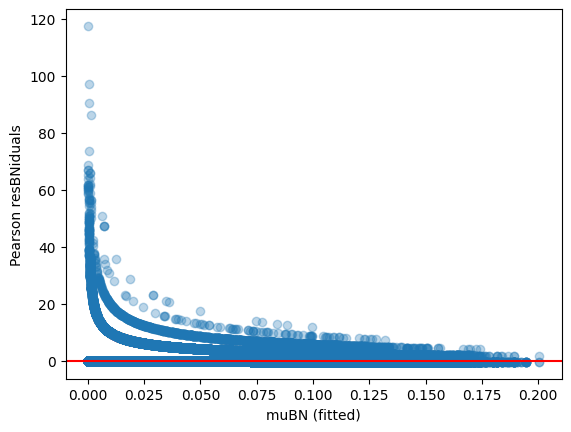

In [87]:
resBN = model_BN.resid_pearson
muBN = model_BN.fittedvalues

plt.scatter(muBN, resBN, alpha=0.3)
plt.axhline(0, color='red')
plt.xlabel("muBN (fitted)")
plt.ylabel("Pearson resBNiduals")

Text(0, 0.5, 'Pearson resIGiduals')

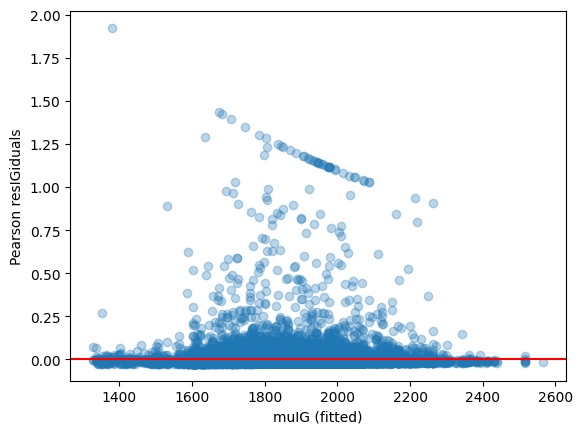

In [88]:
resIG = model_IG.resid_pearson
muIG = model_IG.fittedvalues

plt.scatter(muIG, resIG, alpha=0.3)
plt.axhline(0, color='red')
plt.xlabel("muIG (fitted)")
plt.ylabel("Pearson resIGiduals")

Probaremos especificacion del modelo con test RESET, donde H0 es modelo bien especificado y H1 mal especificado. Power incluira el modelo elevado a p (2,3,etc.) y testeara incluyendo eso. (A mayor power tiende a rechazar mas)

In [89]:
print(linear_reset(model_BN, power=2, use_f=True))

<F test: F=2618.197866376016, p=0.0, df_denom=6.78e+05, df_num=1>


El modelo estaria mal especificado; esto es un diagnostico, no quiere decir que el modelo no sirva si no que le queda relaciones por captar (cuadrados, cubos, relaciones, conitnuidad, bins). Independiente de ello, lo utilizaremos (otro tipo de modelos pueden llegar a conseguir mejores resultados como GAM, Zeros, etc.)

In [90]:
print(linear_reset(model_IG, power=3, use_f=True))

<F test: F=2.1135469331441143, p=0.12082912561681591, df_denom=2.64e+04, df_num=2>


modelo bien especificado

PREDICCIONES Y PRIMAS

Utilizando los modelos, predecimos frequencia y severidad (la frequencia con el offset de exposure ya esta ajustada a a la exposicion). Y calculamos las primas puras (pure premium) como la multiplicacion de estos valores

In [91]:
freq["pred_freq"] = model_BN.predict(freq)
freq["pred_sev"] = model_IG.predict(freq)
freq["prima_pura"] = freq["pred_freq"] * freq["pred_sev"]

sev["pred_freq"] = model_BN.predict(freq)
sev["pred_sev"] = model_IG.predict(freq)
sev["prima_pura"] = sev["pred_freq"] * sev["pred_sev"]

freq[["pred_freq", "pred_sev","prima_pura"]].head()

,pred_freq,pred_sev,prima_pura
0,0.15502,1940.7,300.84
1,0.15502,1940.7,300.84
2,0.12254,1792.5,219.65
3,0.11891,1861.6,221.37
4,0.11891,1861.6,221.37


In [92]:
intercept_BN = np.exp(model_BN.params.filter(like="Intercept"))
intercept_IG = np.exp(model_IG.params.filter(like="Intercept"))
prima_base = int(intercept_BN*intercept_IG)

print(
f"""Prima media: {freq["prima_pura"].mean()}
Prima media ponderada: {np.average(freq["prima_pura"], weights=freq["Exposure"])}
Prima Base: {prima_base}"""
)

Prima media: 201.88100192979059
Prima media ponderada: 191.2483194353142
Prima Base: 205


Si hubiera gastos, impuestos, margen, etc. (en este punto se podria tambien agregar un recargo por BonuSMalus)

In [93]:
G_fijos = 50
Impuestos = 0.05
Margen = 0.03
G_var = 0.1

In [94]:
freq["prima_final"] = (freq["prima_pura"] + G_fijos)/(1-Impuestos-Margen-G_var)

print(
f""" {freq[["pred_freq", "pred_sev","prima_pura", "prima_final"]]}
Prima Final media: {freq["prima_final"].mean()}
{freq["prima_final"].describe()}
"""
)

         pred_freq  pred_sev  prima_pura  prima_final
0         0.15502    1940.7      300.84       427.85
1         0.15502    1940.7      300.84       427.85
2         0.12254    1792.5      219.65       328.85
3         0.11891    1861.6      221.37       330.94
4         0.11891    1861.6      221.37       330.94
...           ...       ...         ...          ...
678008     0.1689    1928.0      325.64        458.1
678009     0.1689    1928.0      325.64        458.1
678010    0.14637    1902.2      278.43       400.52
678011     0.1195    1927.8      230.38       341.92
678012    0.12441    2002.8      249.17       364.85

[678013 rows x 4 columns]
Prima Final media: 307.17195357291536
count   6.7801e+05
mean        307.17
std         74.802
min         194.82
25%         251.46
50%         292.93
75%          347.1
max         571.81
Name: prima_final, dtype: float64



Diagnostico de predicciones

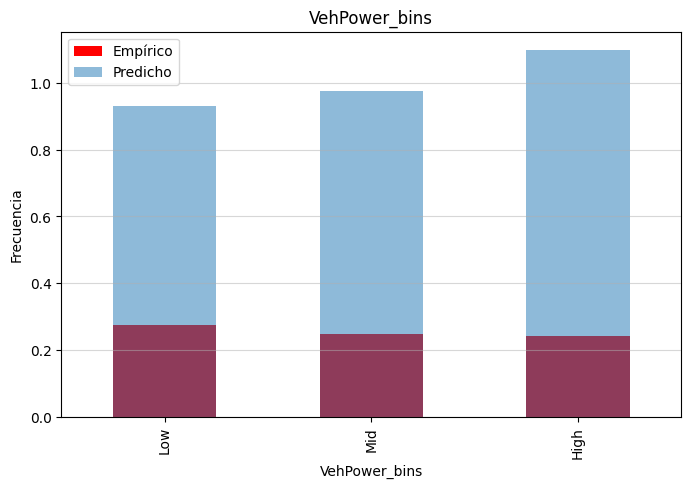

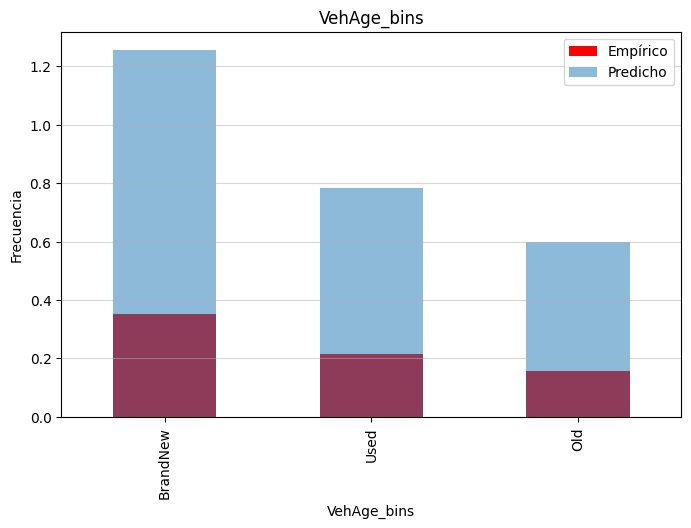

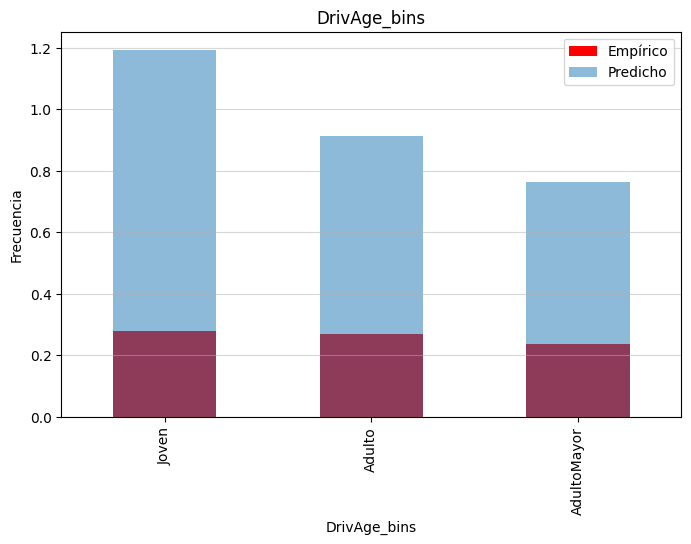

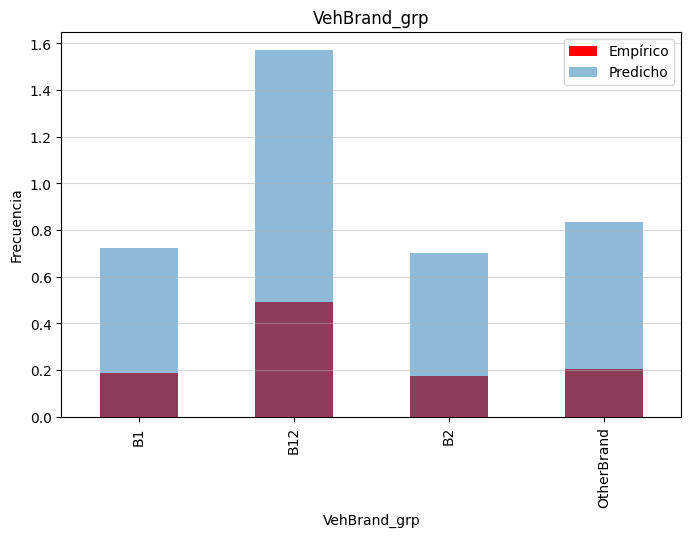

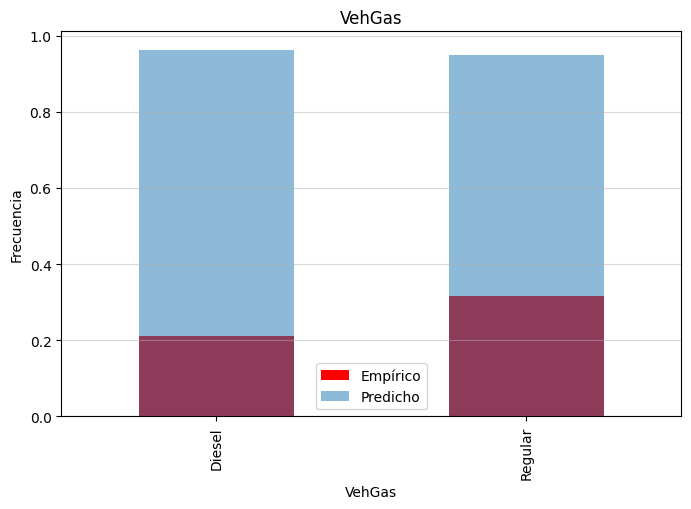

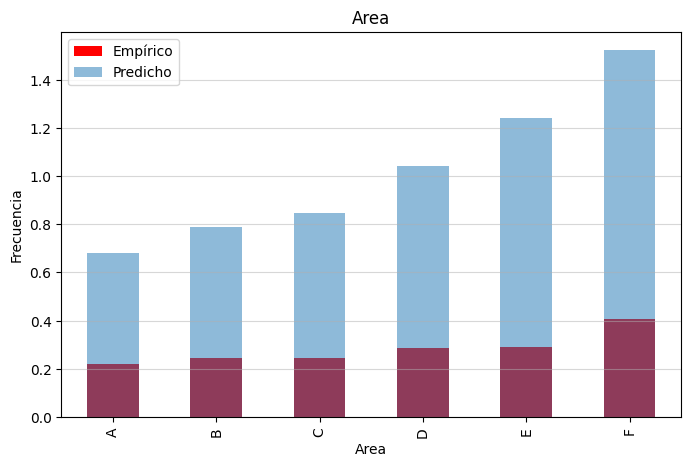

In [95]:
for var in vars_model:
    if "Exposure" is None:
        freq_use = freq.copy()
        freq_use["emp"] = freq_use["ClaimNb"]
        freq_use["pred"] = freq_use["pred_freq"]
    else:
        freq_use = freq.copy()
        freq_use["emp"] = freq_use["ClaimNb"] / freq_use["Exposure"]
        freq_use["pred"] = freq_use["pred_freq"] / freq_use["Exposure"]

    tab = freq_use.groupby(var).agg({"emp":"mean", "pred":"mean"})

    plt.figure(figsize=(8,5))
    tab["emp"].plot(kind="bar", alpha=1, label="Empírico", color="red")
    tab["pred"].plot(kind="bar", alpha=0.5, label="Predicho")
    plt.title(f"{var}")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(axis="y", alpha=.5)
    plt.show()

Sobreestima la frecuencia

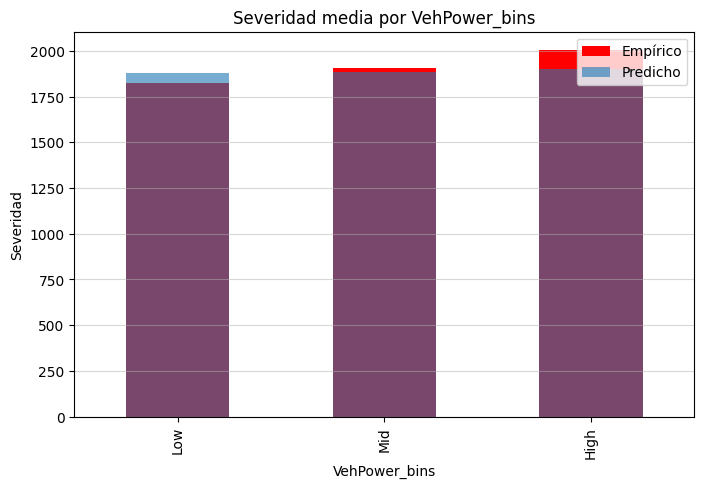

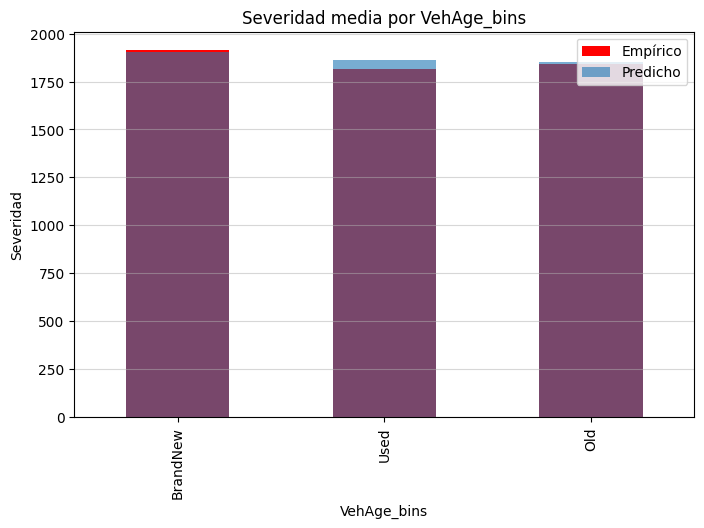

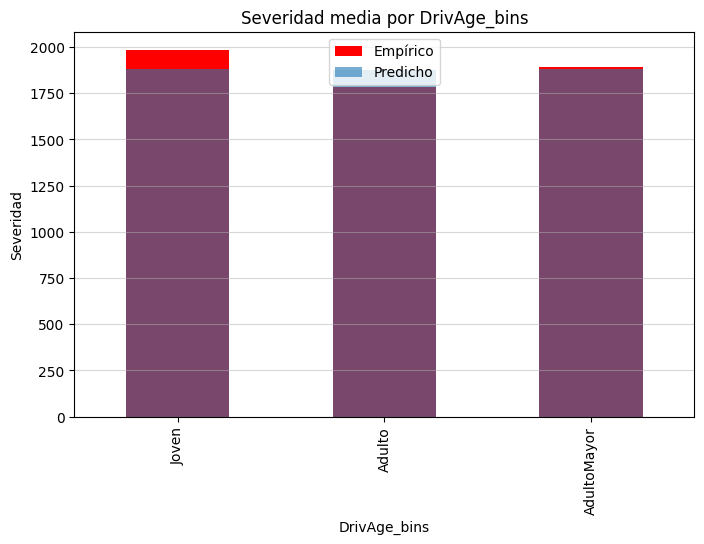

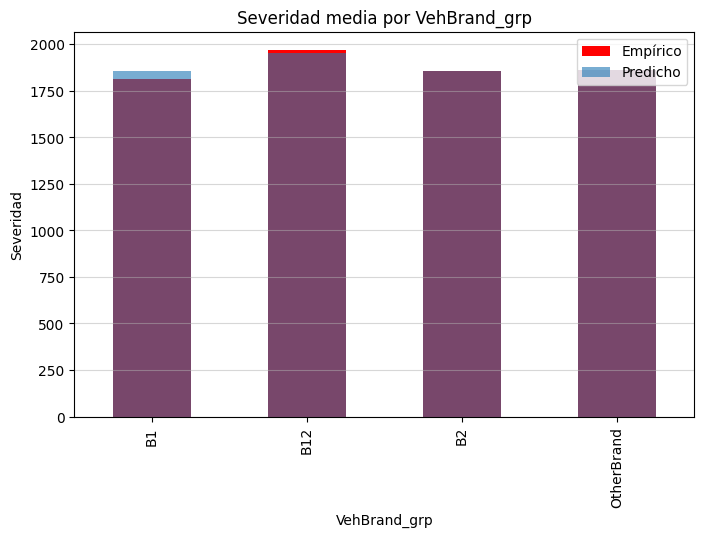

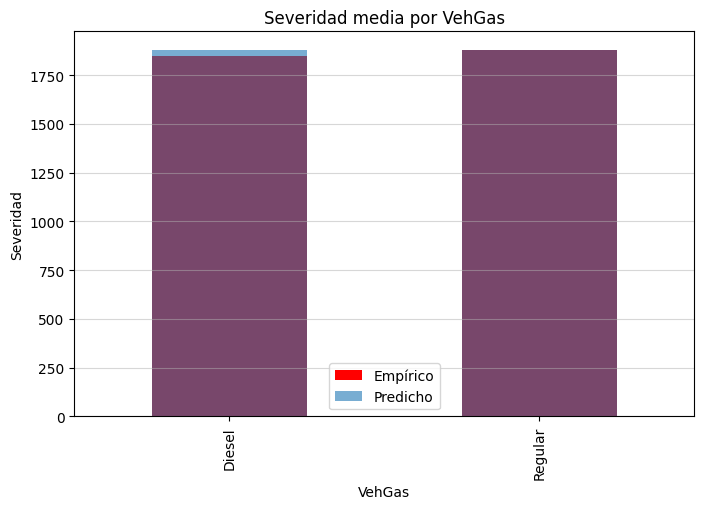

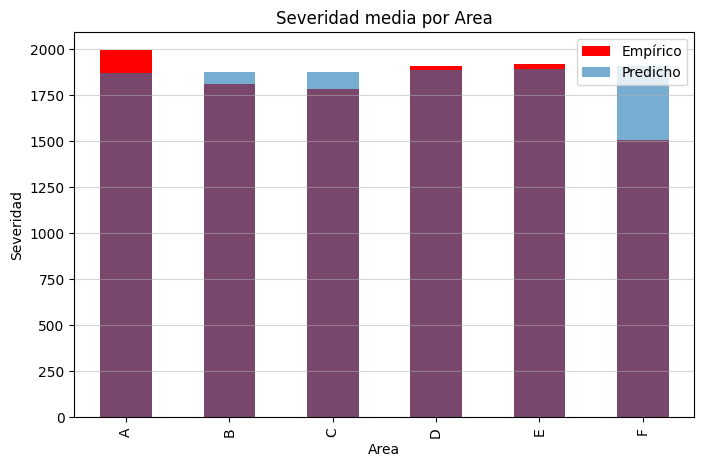

In [96]:
freq_sev = freq_sev.copy()
freq_sev["emp"]  = freq_sev["ClaimAmount"]
freq_sev["pred"] = freq["pred_sev"]

for var in vars_model:
    tab = freq_sev.groupby(var).agg(
        emp=("emp", "mean"),
        pred=("pred", "mean")
    )

    plt.figure(figsize=(8, 5))
    tab["emp"].plot(kind="bar", label="Empírico", alpha=1, color="red")
    tab["pred"].plot(kind="bar", label="Predicho", alpha=0.6)
    plt.title(f"Severidad media por {var}")
    plt.ylabel("Severidad")
    plt.legend()
    plt.grid(axis="y", alpha=0.5)
    plt.show()


Y estima con precision la severidad

Coeficientes multiplicativos:

In [97]:
rel_freq = np.exp(model_BN.params)
rel_sev = np.exp(model_IG.params)
print(
f"""
El valor para las categorias base es 1

==============Frecuencia==============
{rel_freq}


==============Severidad==============
{rel_sev}""")


El valor para las categorias base es 1

==============Frecuencia==============
Intercept                     0.097123
VehPower_bins[T.Mid]            0.9704
VehPower_bins[T.High]          0.91605
VehAge_bins[T.Used]            0.93309
VehAge_bins[T.Old]             0.75973
DrivAge_bins[T.Adulto]         0.89184
DrivAge_bins[T.AdultoMayor]    0.82124
VehBrand_grp[T.B12]             1.3378
VehBrand_grp[T.B2]              1.0018
VehBrand_grp[T.OtherBrand]      1.0244
VehGas[T.Regular]                1.059
Area[T.B]                       1.0575
Area[T.C]                       1.1174
Area[T.D]                       1.2632
Area[T.E]                       1.3763
Area[T.F]                       1.4564
dtype: float64


==============Severidad==============
Intercept                      2118.1
VehPower_bins[T.Mid]           1.0386
VehPower_bins[T.High]          1.1149
VehAge_bins[T.Used]           0.95774
VehAge_bins[T.Old]             0.9658
DrivAge_bins[T.Adulto]        0.89022
DrivAge_bins[

GRILLA TARIFARIA (distintas combinaciones y sus primas)

In [98]:
categorias = {v: freq[v].unique() for v in vars_model}

grilla = pd.DataFrame(
    list(product(*categorias.values())),
    columns=categorias.keys())

grilla["Pred_freq"] = model_BN.predict(grilla)
grilla["Pred_sev"] = model_IG.predict(grilla)
grilla["Prima_pura"] = grilla["Pred_freq"]*grilla["Pred_sev"]
grilla

,VehPower_bins,VehAge_bins,DrivAge_bins,VehBrand_grp,VehGas,Area,Pred_freq,Pred_sev,Prima_pura
0,Low,BrandNew,Adulto,B12,Regular,D,0.15502,1940.7,300.84
1,Low,BrandNew,Adulto,B12,Regular,B,0.12978,1828.8,237.33
2,Low,BrandNew,Adulto,B12,Regular,E,0.1689,1928.0,325.64
3,Low,BrandNew,Adulto,B12,Regular,C,0.13713,1802.8,247.21
4,Low,BrandNew,Adulto,B12,Regular,F,0.17873,1505.1,269.01
...,...,...,...,...,...,...,...,...,...
1291,High,Old,AdultoMayor,B1,Diesel,B,0.058702,1909.5,112.09
1292,High,Old,AdultoMayor,B1,Diesel,E,0.076399,2013.1,153.8
1293,High,Old,AdultoMayor,B1,Diesel,C,0.062027,1882.3,116.75
1294,High,Old,AdultoMayor,B1,Diesel,F,0.080846,1571.5,127.05


Asi concluiriamos el uso de GLM para este dataset. El trabajo actuarial sin embargo no debe concluir con esto, pues como se menciono, existen otros modelos que pueden mejorar las estimaciones y que idealmente se tienen que aplicar y comparar.

No solo eso, existen elementos que se pueden sumar a este analisis, como k-folds, lift curves, qq y boxplots, cómo las categorias acumulan presencia y ausencia de reclamos, etc.